# All needed imports

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Conv2D, Reshape, UpSampling2D, MaxPool2D, Dense, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [2]:
sess = tf.Session()
K.set_session(sess)

# Load mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test .astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test,  (len(x_test),  28, 28, 1))

y_train_cat = to_categorical(y_train).astype(np.float32)
y_test_cat  = to_categorical(y_test).astype(np.float32)

## Create VAE submodels 

In [3]:
batch_size = 500
latent_dim = 49
dropout_rate = 0.3

### Encoder

In [4]:
input_vae_encoder = Input(shape=(28, 28, 1))

x = Conv2D(32, kernel_size=(5, 5))(input_vae_encoder)
x = LeakyReLU()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(16, kernel_size=(5, 5))(x)
x = LeakyReLU()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

begin_of_dense = Flatten()(x)
x = LeakyReLU()(begin_of_dense)
x = Dense(latent_dim * 4)(x)
x = LeakyReLU()(x)
encoded = Dense(latent_dim, activation='relu')(x)
vae_encoder = Model(input_vae_encoder, encoded, name='EncoderVAE')
# vae_encoder.compile(loss='mse', optimizer=Adam())
# vae_encoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



### Decoder

In [5]:
input_vae_decoder = Input(shape=(latent_dim,))

# x = LeakyReLU()(input_vae_decoder)
x = Dense(49)(input_vae_decoder)
x = Reshape(target_shape=(7, 7, 1))(x)
x = Conv2D(16, kernel_size=(7, 7), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(32, kernel_size=(5, 5), padding='same')(x)
x = LeakyReLU()(x)
x = UpSampling2D(size=(2, 2))(x)
decoded = Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid')(x)
vae_decoder = Model(input_vae_decoder, decoded, name='DecoderVAE')
# vae_decoder.compile(loss='mse', optimizer=Adam())
# vae_decoder.summary()

### VAE Model

In [6]:
vae_model = Model(input_vae_encoder, vae_decoder(vae_encoder(input_vae_encoder)), name='VAE')
vae_model.compile(loss='binary_crossentropy', optimizer='adam')
vae_model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
EncoderVAE (Model)           (None, 49)                73673     
_________________________________________________________________
DecoderVAE (Model)           (None, 28, 28, 1)         17651     
Total params: 91,324
Trainable params: 91,324
Non-trainable params: 0
_________________________________________________________________


### VAE Model Training


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 139us/step - loss: 0.2701 - val_loss: 0.1784


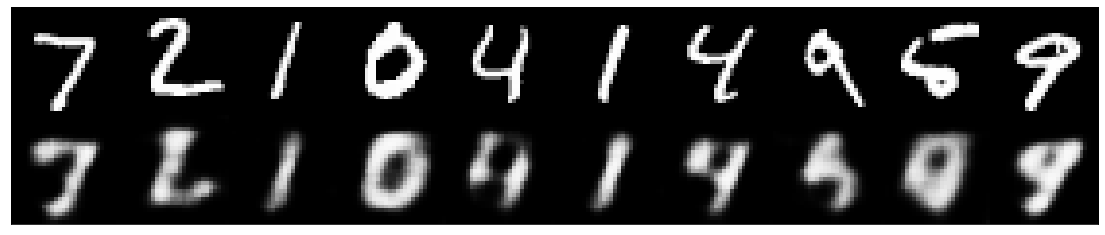

Epoch 2/100
60000/60000 [==============================] - 7s 113us/step - loss: 0.1563 - val_loss: 0.1380
Epoch 3/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.1289 - val_loss: 0.1193
Epoch 4/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.1168 - val_loss: 0.1106
Epoch 5/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.1101 - val_loss: 0.1061
Epoch 6/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.1061 - val_loss: 0.1031
Epoch 7/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.1034 - val_loss: 0.1006
Epoch 8/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.1007 - val_loss: 0.0984
Epoch 9/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.0992 - val_loss: 0.0965
Epoch 10/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0976 - val_loss: 0.0966
Epoch 11/100
60000/60000 [==========

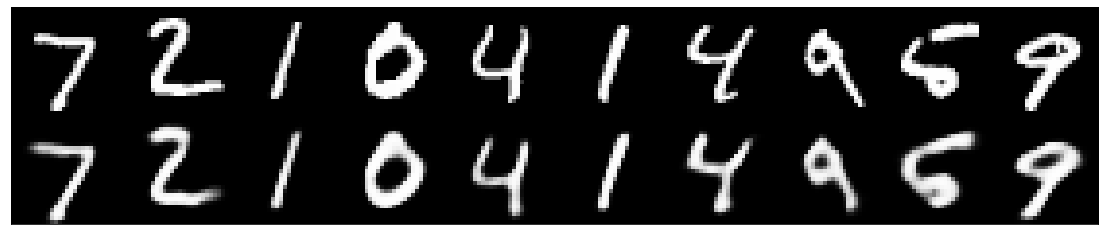

Epoch 13/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.0939 - val_loss: 0.0918
Epoch 14/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.0930 - val_loss: 0.0918
Epoch 15/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0922 - val_loss: 0.0905
Epoch 16/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.0914 - val_loss: 0.0902
Epoch 17/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0907 - val_loss: 0.0887
Epoch 18/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0901 - val_loss: 0.0883
Epoch 19/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0895 - val_loss: 0.0880
Epoch 20/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.0890 - val_loss: 0.0871
Epoch 21/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0886 - val_loss: 0.0870
Epoch 22/100
60000/60000 [==

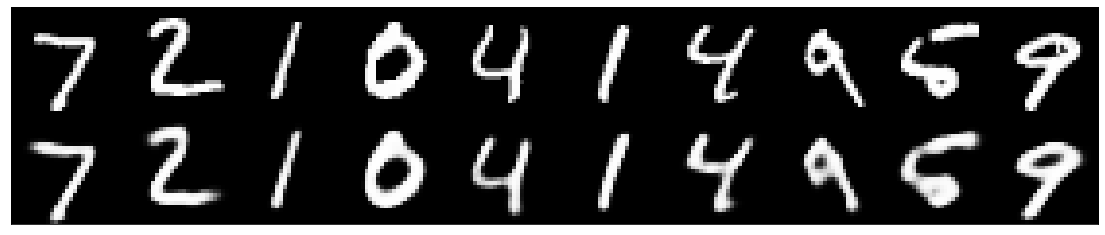

Epoch 24/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0874 - val_loss: 0.0859
Epoch 25/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0869 - val_loss: 0.0876
Epoch 26/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0868 - val_loss: 0.0850
Epoch 27/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0864 - val_loss: 0.0849
Epoch 28/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0861 - val_loss: 0.0848
Epoch 29/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0859 - val_loss: 0.0842
Epoch 30/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0855 - val_loss: 0.0840
Epoch 31/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0854 - val_loss: 0.0845
Epoch 32/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0851 - val_loss: 0.0851
Epoch 33/100
60000/60000 [==

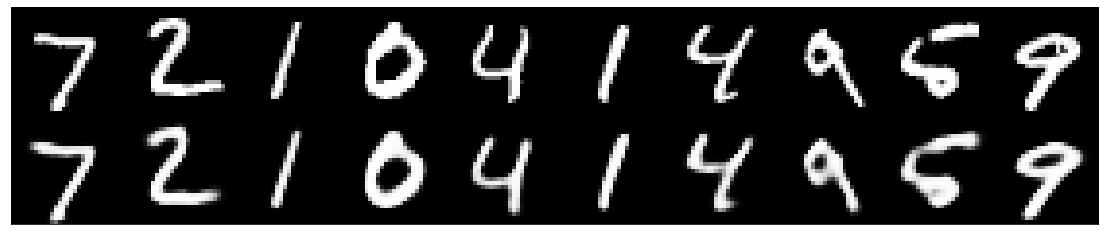

Epoch 35/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0845 - val_loss: 0.0832
Epoch 36/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0843 - val_loss: 0.0834
Epoch 37/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0843 - val_loss: 0.0831
Epoch 38/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0839 - val_loss: 0.0825
Epoch 39/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0839 - val_loss: 0.0825
Epoch 40/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0837 - val_loss: 0.0823
Epoch 41/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.0835 - val_loss: 0.0820
Epoch 42/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0835 - val_loss: 0.0820
Epoch 43/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.0832 - val_loss: 0.0834
Epoch 44/100
60000/60000 [==

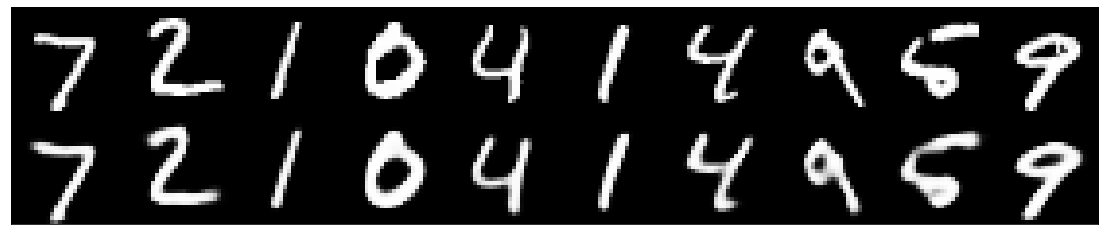

Epoch 46/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.0828 - val_loss: 0.0818
Epoch 47/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0827 - val_loss: 0.0817
Epoch 48/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0825 - val_loss: 0.0811
Epoch 49/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0824 - val_loss: 0.0815
Epoch 50/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0824 - val_loss: 0.0808
Epoch 51/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0822 - val_loss: 0.0818
Epoch 52/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0821 - val_loss: 0.0808
Epoch 53/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0819 - val_loss: 0.0807
Epoch 54/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0819 - val_loss: 0.0810
Epoch 55/100
60000/60000 [==

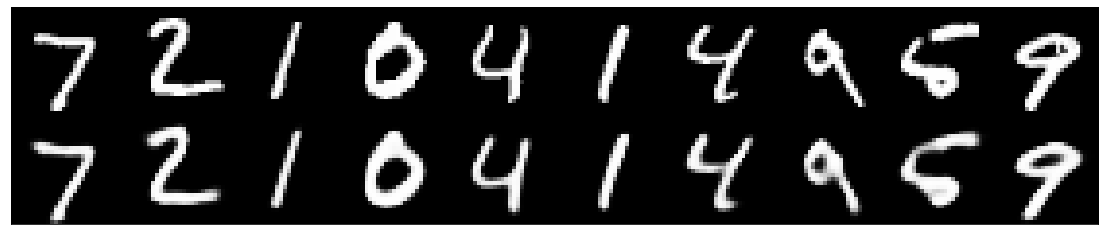

Epoch 57/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0816 - val_loss: 0.0811
Epoch 58/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0814 - val_loss: 0.0812
Epoch 59/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0814 - val_loss: 0.0801
Epoch 60/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0813 - val_loss: 0.0802
Epoch 61/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0812 - val_loss: 0.0802
Epoch 62/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0810 - val_loss: 0.0802
Epoch 63/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0810 - val_loss: 0.0801
Epoch 64/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0808 - val_loss: 0.0801
Epoch 65/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0807 - val_loss: 0.0803
Epoch 66/100
60000/60000 [==

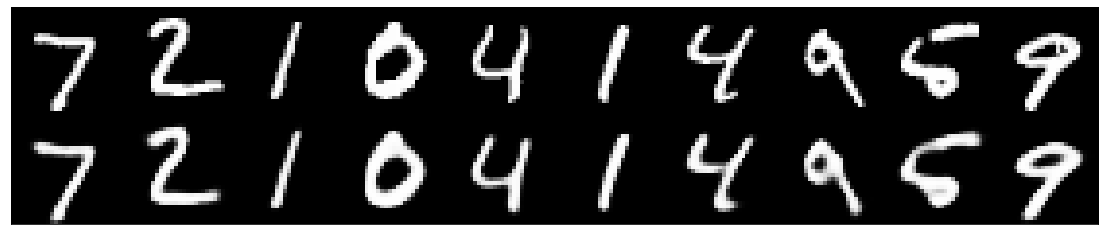

Epoch 68/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0804 - val_loss: 0.0796
Epoch 69/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0803 - val_loss: 0.0796
Epoch 70/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0801 - val_loss: 0.0792
Epoch 71/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0801 - val_loss: 0.0810
Epoch 72/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0801 - val_loss: 0.0792
Epoch 73/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0799 - val_loss: 0.0793
Epoch 74/100
60000/60000 [==============================] - 7s 115us/step - loss: 0.0799 - val_loss: 0.0792
Epoch 75/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0797 - val_loss: 0.0794
Epoch 76/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0796 - val_loss: 0.0797
Epoch 77/100
60000/60000 [==

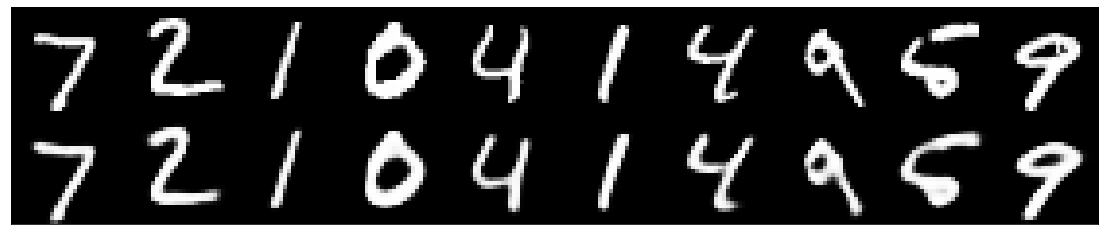

Epoch 79/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0794 - val_loss: 0.0784
Epoch 80/100
60000/60000 [==============================] - 7s 115us/step - loss: 0.0794 - val_loss: 0.0785
Epoch 81/100
60000/60000 [==============================] - 7s 115us/step - loss: 0.0793 - val_loss: 0.0790
Epoch 82/100
60000/60000 [==============================] - 7s 115us/step - loss: 0.0792 - val_loss: 0.0783
Epoch 83/100
60000/60000 [==============================] - 7s 121us/step - loss: 0.0792 - val_loss: 0.0784
Epoch 84/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0791 - val_loss: 0.0781
Epoch 85/100
60000/60000 [==============================] - 7s 122us/step - loss: 0.0789 - val_loss: 0.0780
Epoch 86/100
60000/60000 [==============================] - 7s 122us/step - loss: 0.0790 - val_loss: 0.0778
Epoch 87/100
60000/60000 [==============================] - 7s 121us/step - loss: 0.0789 - val_loss: 0.0786
Epoch 88/100
60000/60000 [==

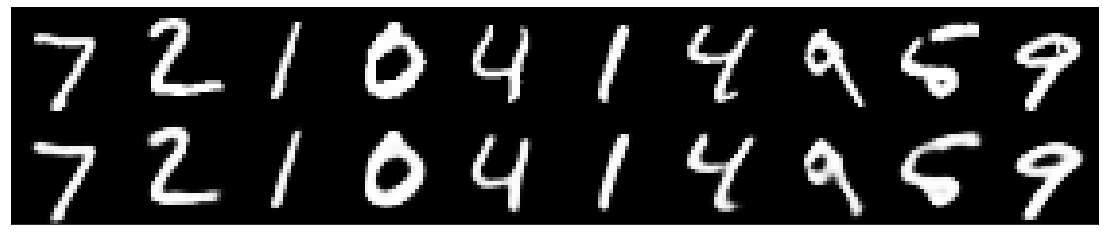

Epoch 90/100
60000/60000 [==============================] - 7s 121us/step - loss: 0.0788 - val_loss: 0.0778
Epoch 91/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0786 - val_loss: 0.0783
Epoch 92/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0786 - val_loss: 0.0777
Epoch 93/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0785 - val_loss: 0.0791
Epoch 94/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0785 - val_loss: 0.0781
Epoch 95/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0785 - val_loss: 0.0777
Epoch 96/100
60000/60000 [==============================] - 7s 119us/step - loss: 0.0785 - val_loss: 0.0776
Epoch 97/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0783 - val_loss: 0.0773
Epoch 98/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0784 - val_loss: 0.0779
Epoch 99/100
60000/60000 [==

In [7]:
import time

from keras.callbacks import LambdaCallback


imgs = x_test[:batch_size]
# imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

epochs_to_check = np.linspace(0, 100, num=10).astype('int')


digit_size = 28
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()


def on_epoch_end(epoch, logs):
    if epoch in epochs_to_check:
        decoded_imgs = vae_model.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded_imgs[:n_compare])


plt_fig = LambdaCallback(on_epoch_end=on_epoch_end)

start_time = time.time()
vae_model.fit(x_train, x_train,
              batch_size=batch_size,
              epochs=100,
              shuffle=True,
              validation_data=(x_test, x_test),
              callbacks=[plt_fig],
              verbose=1)
print("ALL VAE TRAINING ELAPSED TIME: %s" % (time.time() - start_time))

### Try to decode random codes

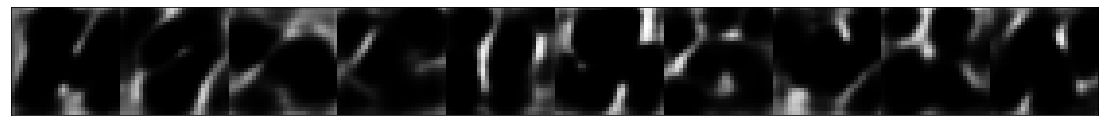

In [15]:
codes = np.random.randn(n_compare, latent_dim)
decoded_from_codes = vae_decoder.predict(codes, batch_size=n_compare)
plot_digits(decoded_from_codes)


# SAVE MODELS

In [16]:
import os
import json

save_path = os.path.join("saved_models", "convolutional_variational_ae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "vae.json"), "w") as f:
    json.dump(vae_model.to_json(), f, indent=4)
vae_model.save_weights(os.path.join(save_path, "vae.h5"))

with open(os.path.join(save_path, "vae_encoder.json"), "w") as f:
    json.dump(vae_encoder.to_json(), f, indent=4)
vae_encoder.save_weights(os.path.join(save_path, "vae_encoder.h5"))

with open(os.path.join(save_path, "vae_decoder.json"), "w") as f:
    json.dump(vae_decoder.to_json(), f, indent=4)
vae_decoder.save_weights(os.path.join(save_path, "vae_decoder.h5"))